In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy.stats import f_oneway
from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

##### Loading Dataset & Information 

In [2]:
# Loading in the Gene Expression Data
gene_expression = pd.read_csv('Data/Liver_GSE14520_U133A.csv')

# Label Encoding the type column where 0 is normal and 1 is HCC
gene_expression['type'] = gene_expression['type'].map({'normal': 0, 'HCC': 1})

gene_expression.head()

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,GSM362958.CEL.gz,1,6.801198,4.553189,6.787790,5.430893,3.250222,6.272688,3.413405,3.374910,...,10.735084,10.398843,12.298551,12.270505,3.855588,3.148321,3.366087,3.199008,3.160388,3.366417
1,GSM362959.CEL.gz,1,7.585956,4.193540,3.763183,6.003593,3.309387,6.291927,3.754777,3.587603,...,11.528447,11.369919,12.867048,12.560433,4.016561,3.282867,3.541994,3.548680,3.460083,3.423348
2,GSM362960.CEL.gz,1,7.803370,4.134075,3.433113,5.395057,3.476944,5.825713,3.505036,3.687333,...,10.892460,10.416151,12.356337,11.888482,3.839367,3.598851,3.516791,3.484089,3.282626,3.512024
3,GSM362964.CEL.gz,1,6.920840,4.000651,3.754500,5.645297,3.387530,6.470458,3.629249,3.577534,...,10.686871,10.524836,12.006596,11.846195,3.867602,3.180472,3.309547,3.425501,3.166613,3.377499
4,GSM362965.CEL.gz,1,6.556480,4.599010,4.066155,6.344537,3.372081,5.439280,3.762213,3.440714,...,11.014454,10.775566,12.657182,12.573076,4.091440,3.306729,3.493704,3.205771,3.378567,3.392938


In [3]:
# Checking for missing values
if gene_expression.isnull().sum().sum() == 0:
    print('No missing values in the dataset')

No missing values in the dataset


In [4]:
# Target Variable is 'type', which is cancerous (HCC) or non-cancerous (Normal)
print('total number of cancerous samples (HCC):', gene_expression['type'].value_counts()[1])
print('total number of non-cancerous samples:', gene_expression['type'].value_counts()[0])

total number of cancerous samples (HCC): 181
total number of non-cancerous samples: 176


The dataset is quiet balanced so no need to perform any additional steps

In [5]:
# Creating a list with all the feature columns names and removing the 'type' and 'samples' columns
feature_columns = gene_expression.columns.tolist()
feature_columns.remove('type')
feature_columns.remove('samples')
print('Number of features (Before Seclection):', len(feature_columns))

Number of features (Before Seclection): 22277


In [6]:
# Dropping the 'samples' column
gene_expression = gene_expression.drop('samples', axis=1)

# Normalizing the data
scaler = StandardScaler()
gene_expression[feature_columns] = scaler.fit_transform(gene_expression[feature_columns])

##### Splitting Dataset into training and testing

In [7]:
# Stratified Splitting of the Data into Train and Test Sets
X = gene_expression.drop('type', axis=1)
y = gene_expression['type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

##### Dimensionality Reduction using PCA

In [8]:
# Choose the number of components, for example to retain 95% of variance
pca = PCA(n_components=0.95, svd_solver='full')

# Fit and transform the training data
X_train_pca = pca.fit_transform(X_train)

# Convert the transformed data into a DataFrame
X_train_pca = pd.DataFrame(X_train_pca)

# Transform the test data using the same principal components
X_test_pca = pca.transform(X_test)

# Convert the transformed test data into a DataFrame
X_test_pca = pd.DataFrame(X_test_pca)

In [9]:
# Number of features after PCA
print('Number of features (After PCA):', len(X_train_pca.columns))
print('Total Explained Variance:', np.sum(pca.explained_variance_ratio_))

Number of features (After PCA): 208
Total Explained Variance: 0.9501897323931061


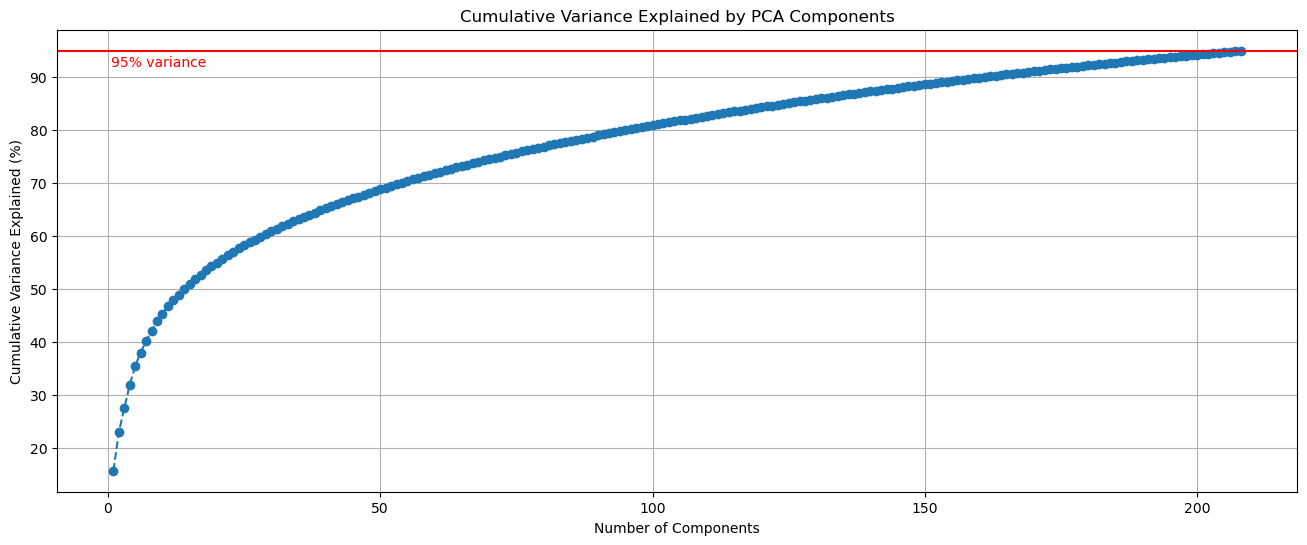

In [10]:
# Assuming 'pca' is your PCA object after fitting to the training data
variance_explained = np.cumsum(pca.explained_variance_ratio_) * 100

plt.figure(figsize=(16, 6))
plt.plot(range(1, len(variance_explained)+1), variance_explained, marker='o', linestyle='--')
plt.title('Cumulative Variance Explained by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained (%)')
plt.axhline(y=95, color='r', linestyle='-') # Highlight the 95% threshold
plt.text(0.5, 92, '95% variance', color = 'red')
plt.grid(True)
plt.show()

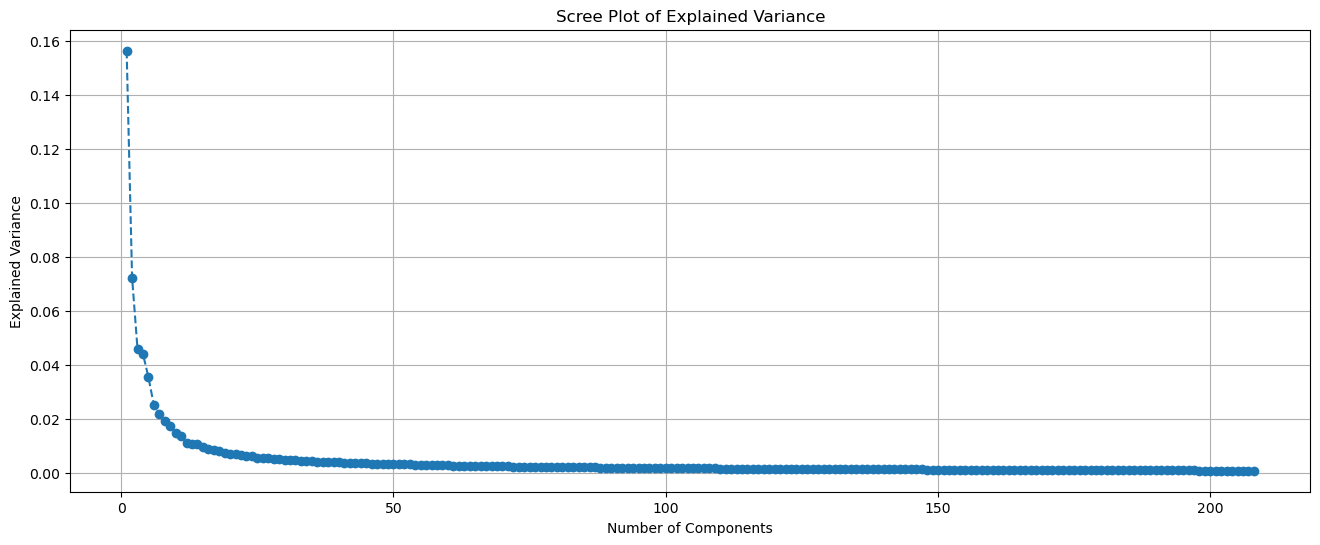

In [11]:
# Scree Plot of the explained variance
plt.figure(figsize=(16, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Scree Plot of Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.grid(True)
plt.show()

In [12]:
# Overwrite the original training and test data with the PCA transformed data
X_train = X_train_pca
X_test = X_test_pca

##### Further feature selection using mRMR

In [13]:
# Calculate F-statistic for each feature
def calc_f_statistic(X, y):
    # Reset indices to ensure alignment
    X_reset = X.reset_index(drop=True)
    y_reset = y.reset_index(drop=True)

    f_stats = {}
    classes = np.unique(y_reset)
    for feature in X_reset.columns:
        # Ensure alignment by using reset indices
        class_samples = [X_reset[feature][y_reset == cls].values for cls in classes]
        f_statistic, p_value = f_oneway(*class_samples)
        f_stats[feature] = f_statistic
    return f_stats


# Calculate Pearson correlation coefficients between all pairs of features
def calc_pearson_corr(X):
    corr_matrix = X.corr().abs()
    # Flatten the correlation matrix and filter out self-correlations (i.e., diagonal elements)
    correlations = [(corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
                    for i in range(len(corr_matrix.columns)) for j in range(i+1, len(corr_matrix.columns))]
    return correlations

# Select top 20 features using mRMR
def select_top_features_mRMR(X, y):
    f_stats = calc_f_statistic(X, y)
    correlations = calc_pearson_corr(X)

    # Sort features based on F-statistic, descending
    sorted_features = sorted(f_stats, key=f_stats.get, reverse=True)

    selected_features = []
    while len(selected_features) < 20:
        remaining_features = list(set(sorted_features) - set(selected_features))
        mrmr_scores = {}
        for feature in remaining_features:
            relevance = f_stats[feature]
            redundancy = np.mean([abs(X[feature].corr(X[selected_feature])) for selected_feature in selected_features if selected_feature in X.columns])
            mrmr_score = relevance / (1 + redundancy) if selected_features else relevance
            mrmr_scores[feature] = mrmr_score
        # Select feature with highest mRMR score
        next_feature = max(mrmr_scores, key=mrmr_scores.get)
        selected_features.append(next_feature)

    return selected_features

In [14]:
top_features = select_top_features_mRMR(X_train, y_train) # Select top 20 features using mRMR

X_train = X_train[top_features]
X_test = X_test[top_features]

##### Training Supervised Models

In [15]:
random_state = 42

In [16]:
# Importing Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

# Importing Evaluation Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [17]:
# Define Evaluation Function

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1)
    print(confusion_matrix(y_test, y_pred))
    print('ROC AUC:', roc_auc)

    # Plot ROC Curve with AUC Score on the plot
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='AUC = %0.3f' % roc_auc)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('ROC Curve for ' + model.__class__.__name__)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

In [36]:
# Logistic Regression
log_reg = LogisticRegression(solver = 'lbfgs', penalty='l2', tol=0.001, dual=False, max_iter=1000, intercept_scaling=1, random_state=random_state)

# XGBoost Classifier
xgb_clf = xgb.XGBClassifier(n_estimators=350, max_depth=6, learning_rate=0.1, random_state=random_state)

# Gaussian Naive Bayes
gnb = GaussianNB(var_smoothing=1e-09)

# Decision Tree Classifier
dt_clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=4, min_samples_split=2, min_samples_leaf=1, random_state=random_state)

# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=35, p=2, metric='minkowski')

# SVM
svm = SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', probability=True, random_state=random_state)

# Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=4, min_samples_split=2, min_samples_leaf=1, random_state=random_state)

Evaluating the Models

Accuracy: 0.9305555555555556
Precision: 0.9705882352941176
Recall: 0.8918918918918919
F1 Score: 0.9295774647887324
[[34  1]
 [ 4 33]]
ROC AUC: 0.9583011583011583


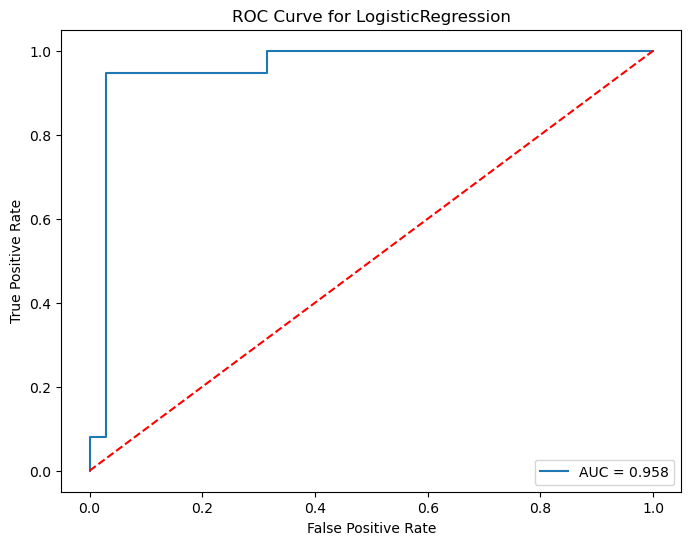

In [35]:
evaluate_model(log_reg, X_train, y_train, X_test, y_test)

Accuracy: 0.9166666666666666
Precision: 0.9696969696969697
Recall: 0.8648648648648649
F1 Score: 0.9142857142857143
[[34  1]
 [ 5 32]]
ROC AUC: 0.955984555984556


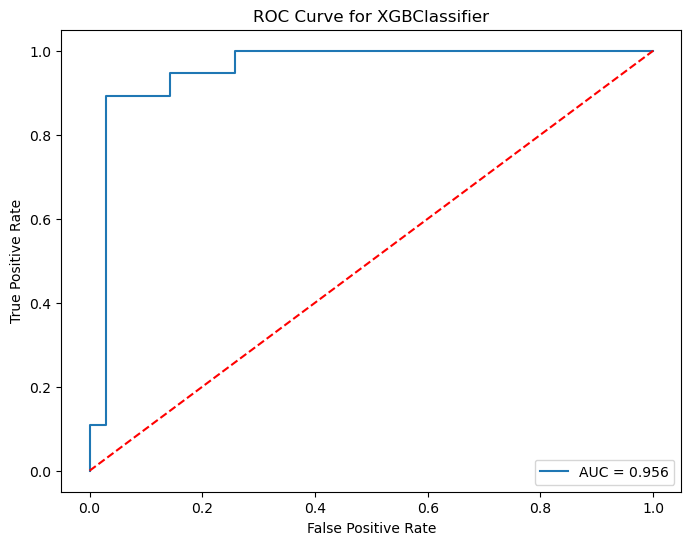

In [37]:
evaluate_model(xgb_clf, X_train, y_train, X_test, y_test)

Accuracy: 0.8055555555555556
Precision: 0.9259259259259259
Recall: 0.6756756756756757
F1 Score: 0.78125
[[33  2]
 [12 25]]
ROC AUC: 0.9444015444015444


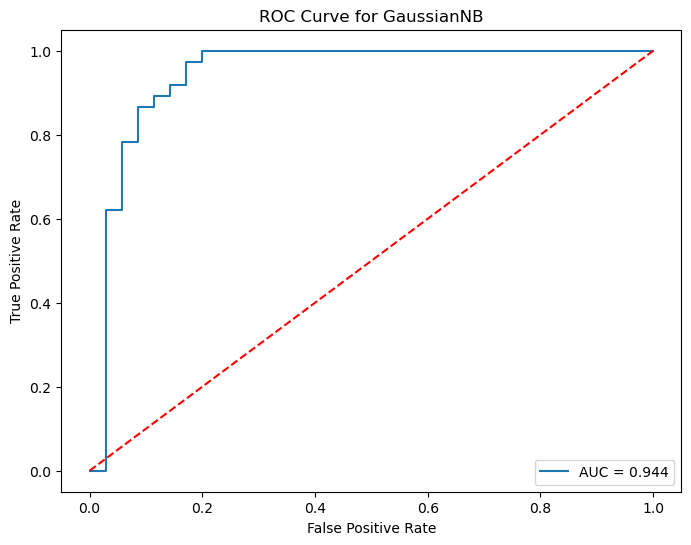

In [21]:
evaluate_model(gnb, X_train, y_train, X_test, y_test)

Accuracy: 0.8472222222222222
Precision: 0.9333333333333333
Recall: 0.7567567567567568
F1 Score: 0.835820895522388
[[33  2]
 [ 9 28]]
ROC AUC: 0.845945945945946


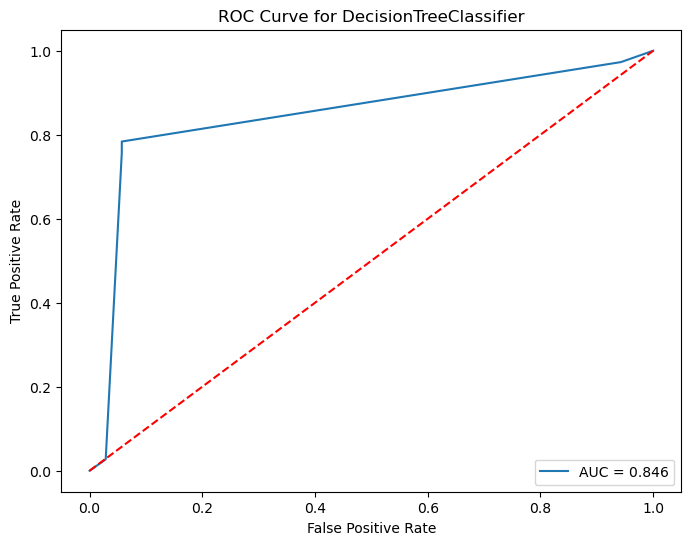

In [22]:
evaluate_model(dt_clf, X_train, y_train, X_test, y_test)

Accuracy: 0.9305555555555556
Precision: 0.9705882352941176
Recall: 0.8918918918918919
F1 Score: 0.9295774647887324
[[34  1]
 [ 4 33]]
ROC AUC: 0.9285714285714285


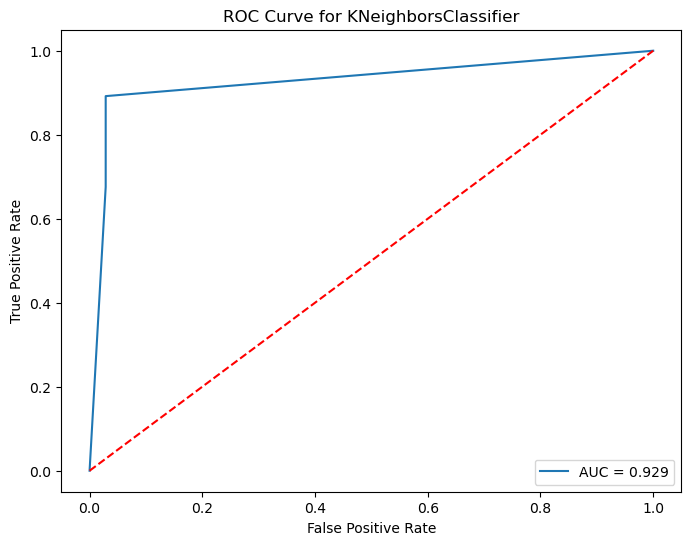

In [23]:
evaluate_model(knn, X_train, y_train, X_test, y_test)

Accuracy: 0.9166666666666666
Precision: 0.9428571428571428
Recall: 0.8918918918918919
F1 Score: 0.9166666666666666
[[33  2]
 [ 4 33]]
ROC AUC: 0.9536679536679536


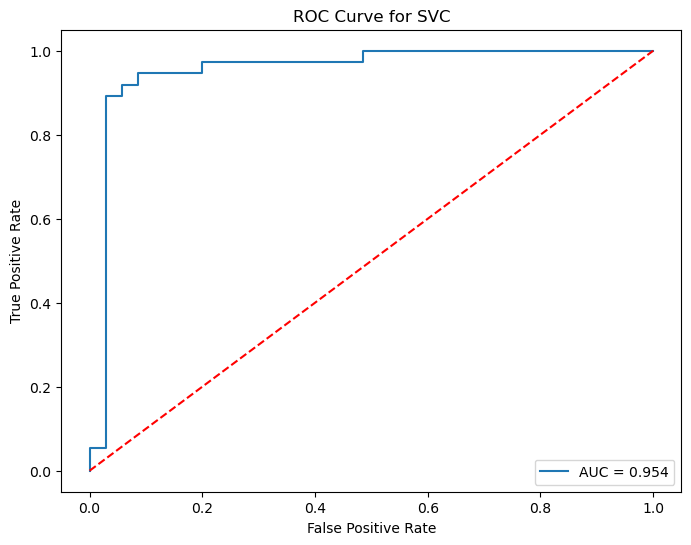

In [24]:
evaluate_model(svm, X_train, y_train, X_test, y_test)

Accuracy: 0.875
Precision: 0.9375
Recall: 0.8108108108108109
F1 Score: 0.8695652173913043
[[33  2]
 [ 7 30]]
ROC AUC: 0.9459459459459459


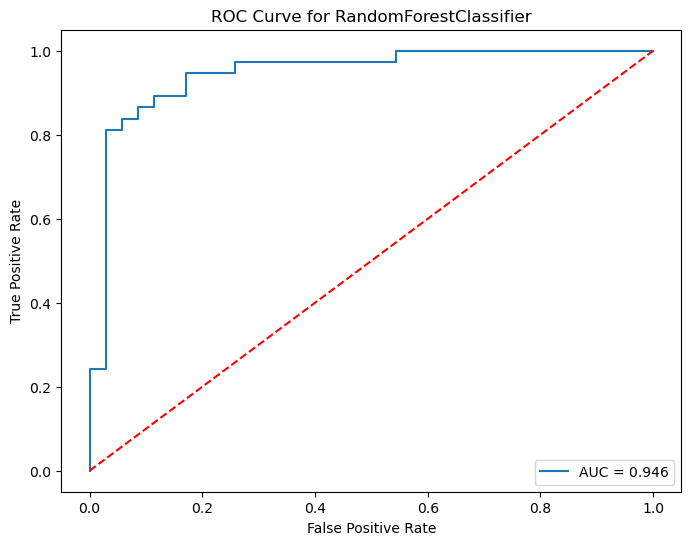

In [25]:
evaluate_model(rf_clf, X_train, y_train, X_test, y_test)